# Analyse de personnalité client - Modélisation

Ce notebook réalise l'analyse non supervisée du jeu de données issu de la **Customer Personality Analysis** disponible sur Kaggle.
Nous allons:
1. Charger et explorer les données
2. Nettoyer et prétraiter le jeu de données
3. Réduire la dimension avec une sélection de variables et une analyse factorielle
4. Appliquer trois méthodes de clustering (k-means, CAH, DBSCAN)
5. Comparer les résultats et profiler les groupes obtenus
6. Conclure

## 1. Chargement et exploration des données

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

df = pd.read_csv('../data/marketing_campaign.csv', sep='	')
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  04-09-2012       58       635         88              546              172   
1  08-03-2014       38        11          1                6                2   
2  21-08-2013       26       426         49              127              111   
3  10-02-2014       26        11          4               20               10   
4  19-01-2014       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0

In [31]:
df.select_dtypes(include='object').columns

Index(['Education', 'Marital_Status', 'Dt_Customer'], dtype='object')

Dans le dataset, nous avons 3 features qui sont des strings, nous allons donc les transformer afin de pouvoir les exploiter

In [ ]:
education_map = {
    '2n Cycle': 1,
    'Basic': 2,
    'Graduation': 3,
    'Master': 4,
    'PhD': 5
}
marital_map = {
    'Single': 1,
    'Divorced': 1,
    'Widow': 1,
    'Together': 2,
    'Married': 2,
    'Alone': 1,
    'Absurd': 1,
    'YOLO': 1
}

df['Education'] = df['Education'].map(education_map)
df['Marital_Status'] = df['Marital_Status'].map(marital_map)

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')


df['Education'] = df['Education'].map(education_map)
df['Marital_Status'] = df['Marital_Status'].map(marital_map)

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_For_Days'] = (reference_date - df['Dt_Customer']).dt.days
df.drop(columns='Dt_Customer', inplace=True)


print("\nAperçu des colonnes transformées :")
print(df[['Education', 'Marital_Status', 'Customer_For_Days']].head())


Aperçu des colonnes transformées :
   Education  Marital_Status  Customer_For_Days
0          3               1                663
1          3               1                113
2          3               2                312
3          3               2                139
4          5               2                161


Afin de rendre les variables exploitables par les algorithmes d’apprentissage automatique, nous avons procédé aux transformations suivantes :

### Niveau d’étude (Education)

Le niveau d'étude a été transformé en variable ordinale selon un ordre croissant de qualification académique, allant de 1 à 5 :
- 2n Cycle	1
- Basic	2
- Graduation	3
- Master	4
- PhD	5

Cette transformation permet de modéliser l’évolution du niveau éducatif de manière cohérente pour les modèles.
### Statut marital (Marital_Status)
Nous avons regroupé les individus en deux grandes catégories :

- 1 : personnes vivant seules
- 2 : personnes en couple

Les modalités atypiques telles que Alone, Absurd ou YOLO ont été intégrées dans la catégorie des personnes seules.
Ce choix repose sur l’hypothèse qu’il s’agit de réponses ironiques ou critiques envers la vie de couple, que nous avons donc interprétées comme un rejet implicite d'une relation conjugale.

### Ancienneté du client (Dt_Customer)

La date d'inscription a été convertie en nombre de jours depuis l’inscription (Customer_For_Days) afin d’apporter une information temporelle exploitable par les modèles.

Ne disposant pas de la date de référence "aujourd’hui", nous avons utilisé la date d'inscription la plus récente du jeu de données comme point de référence.
L’ancienneté a été calculée comme suit :

Cette transformation permet d’intégrer la notion de fidélité du client dans l’analyse : 
Customer_For_Days = Date la plus récente - Dt_Customer

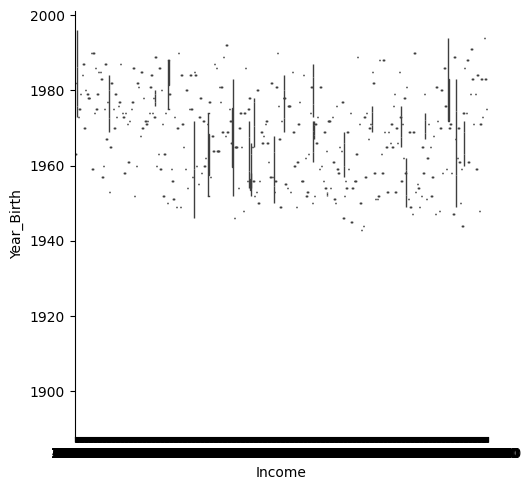

In [39]:
sns.catplot(data=df, x="Income", y="Year_Birth", kind="box")

In [33]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
outlier_pred = iso.fit_predict(df.select_dtypes(include=[np.number]))

df['Outlier_IForest'] = outlier_pred
print(df['Outlier_IForest'].value_counts())

Outlier_IForest
 1    2128
-1     112
Name: count, dtype: int64


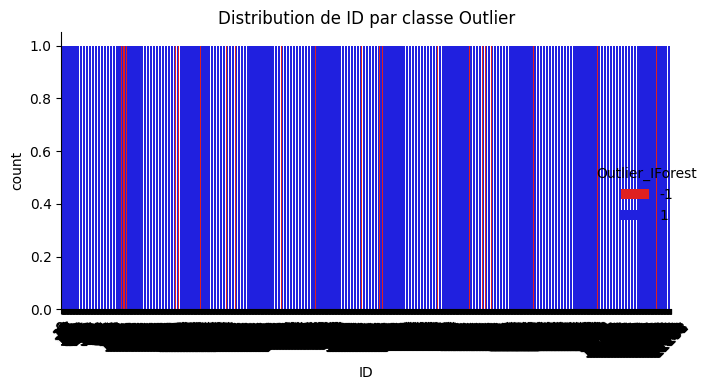

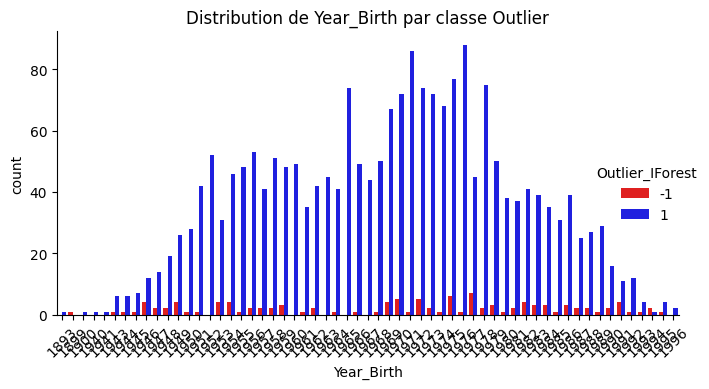

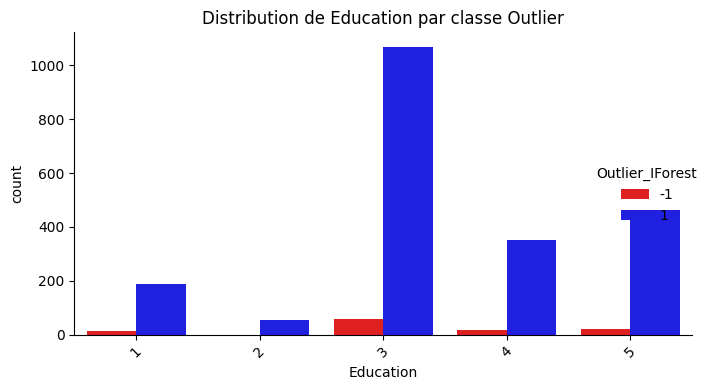

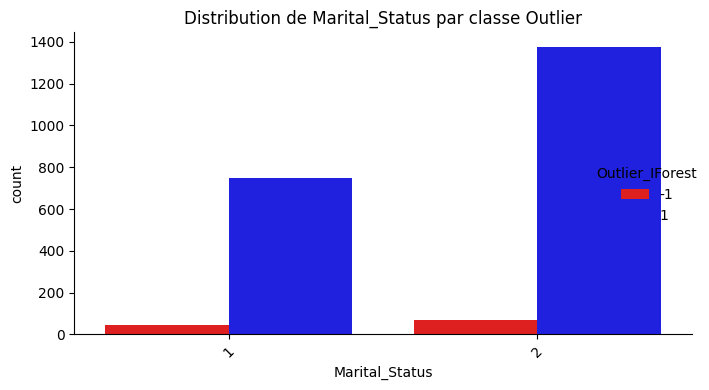

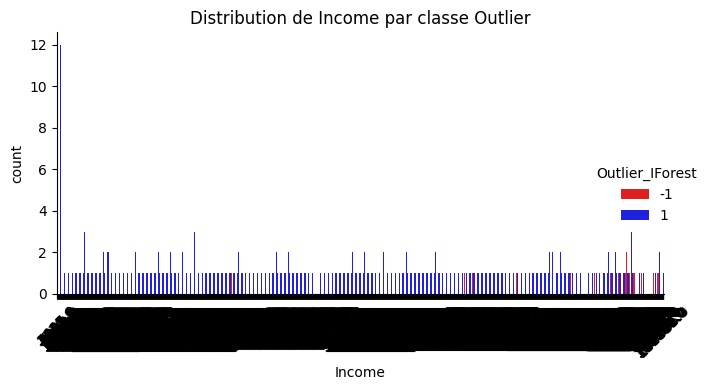

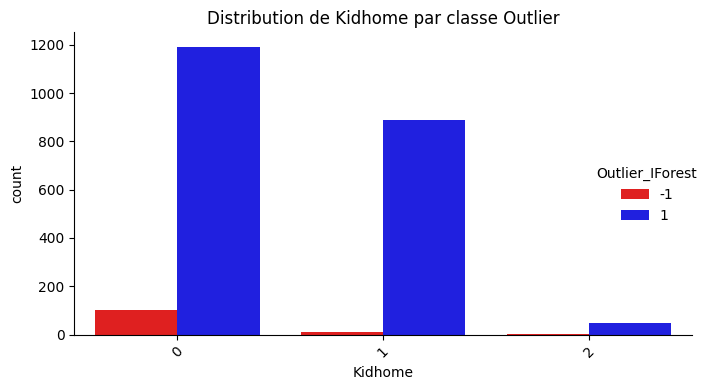

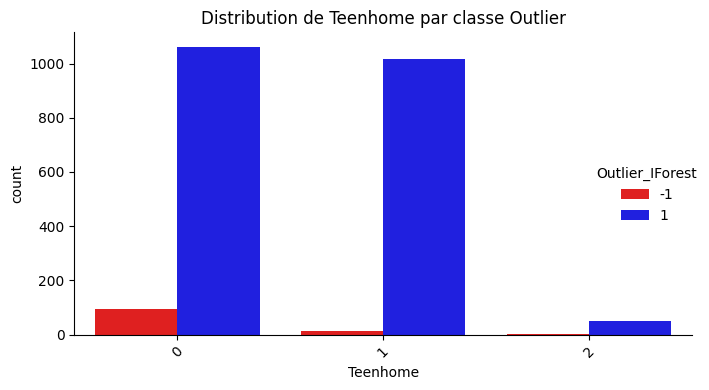

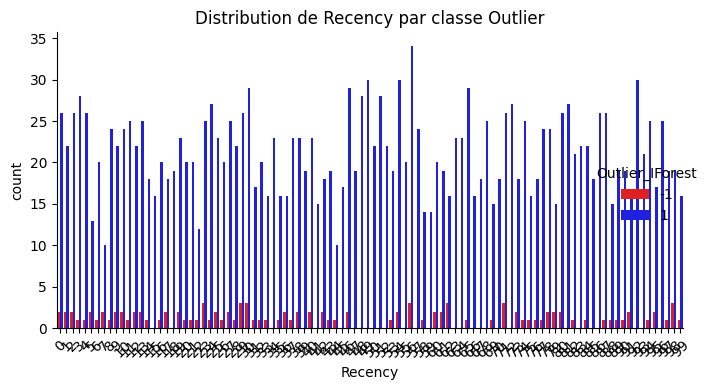

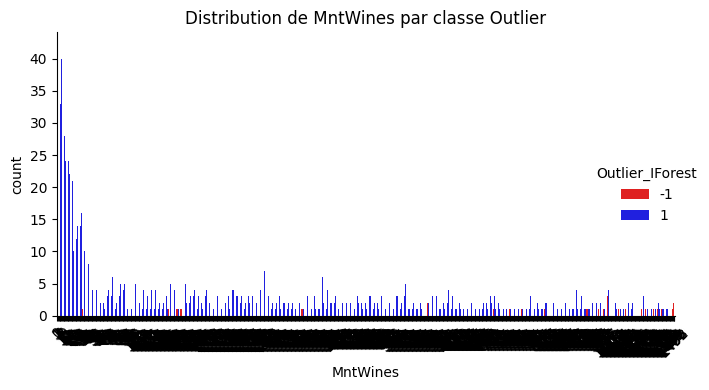

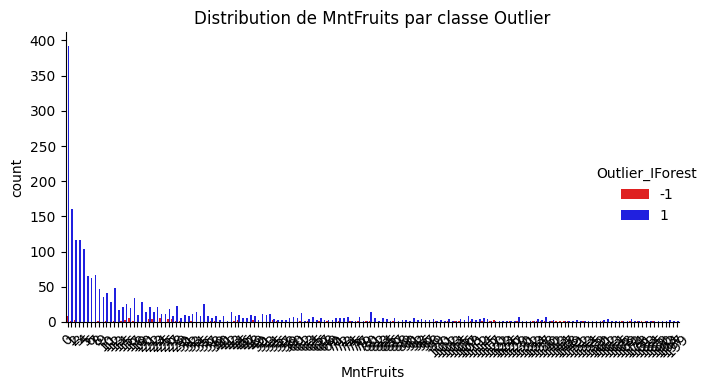

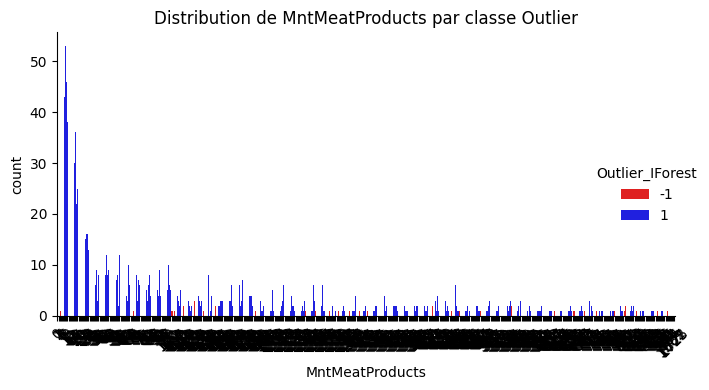

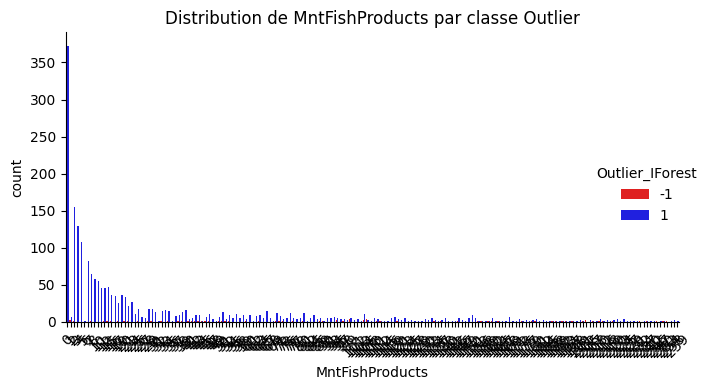

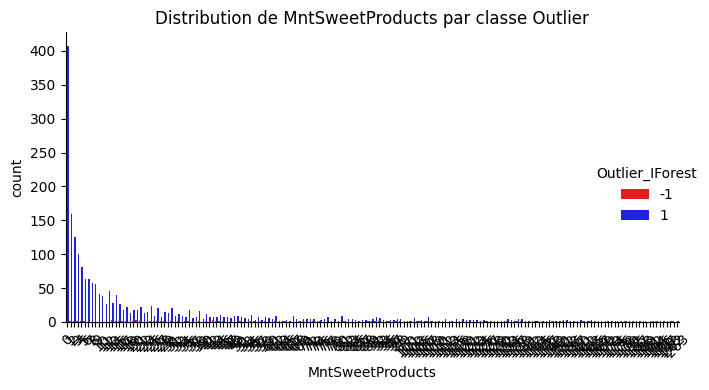

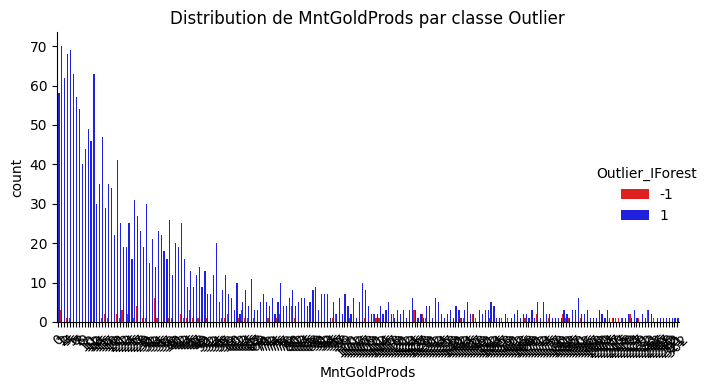

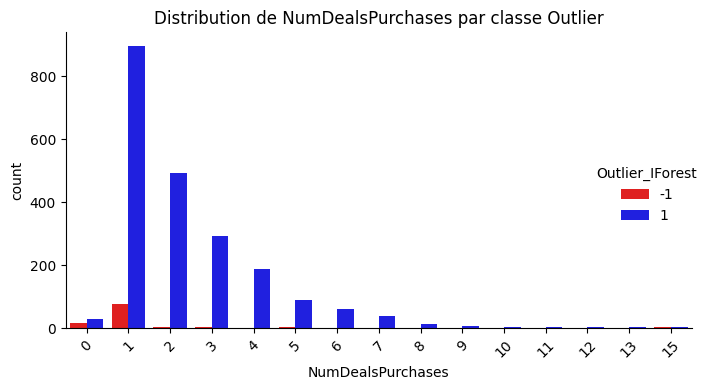

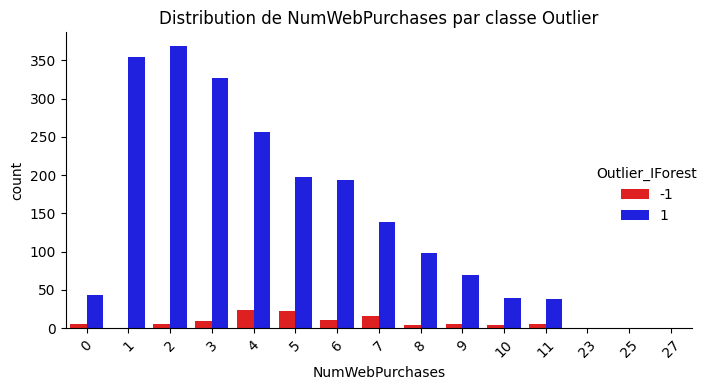

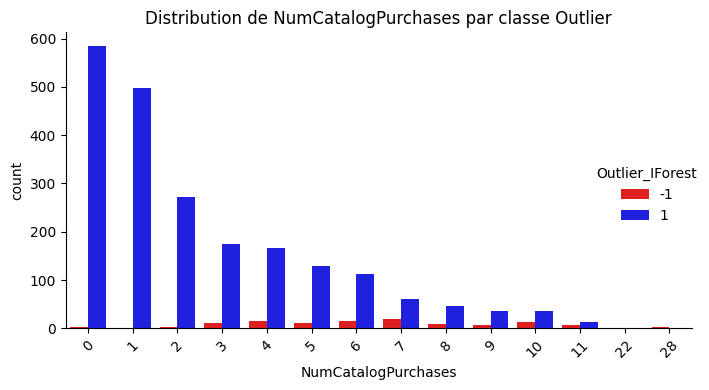

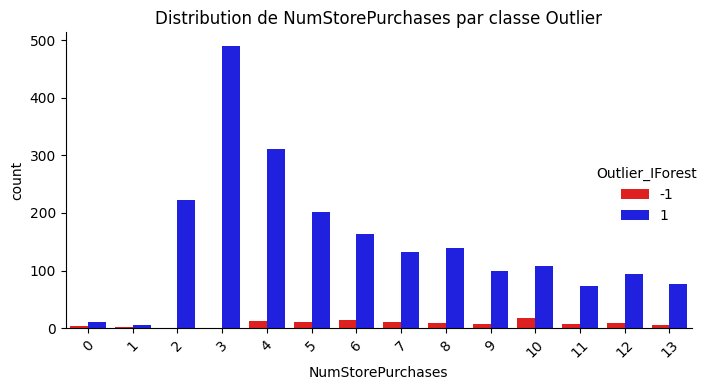

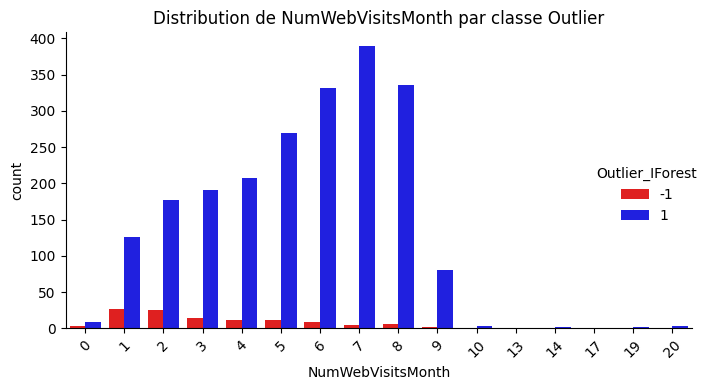

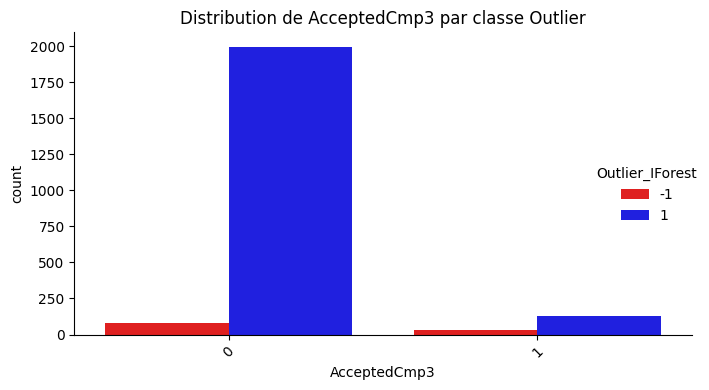

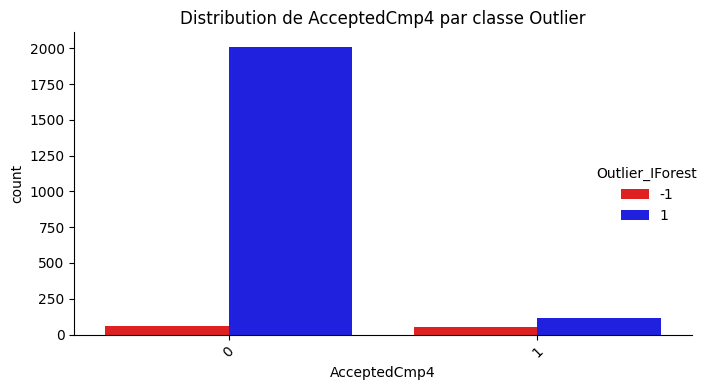

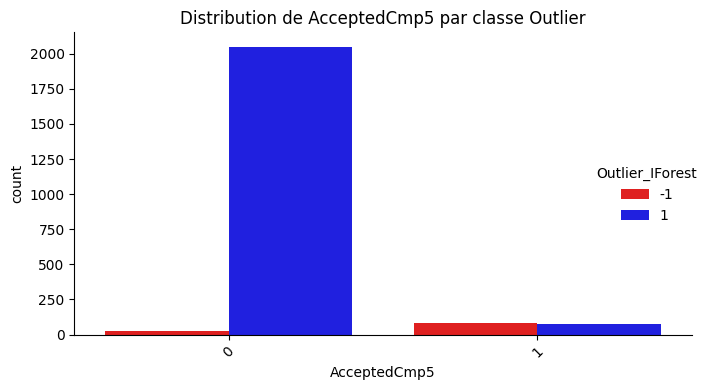

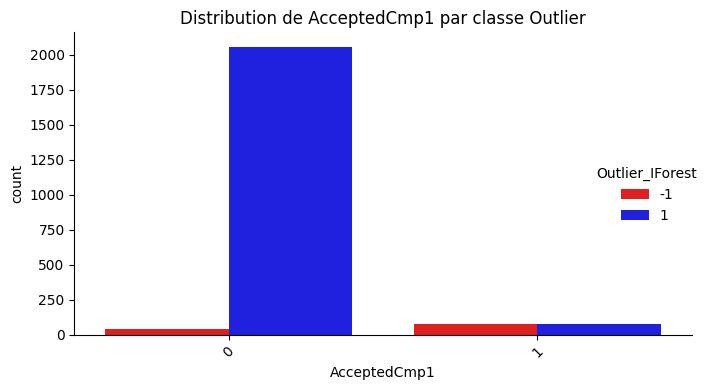

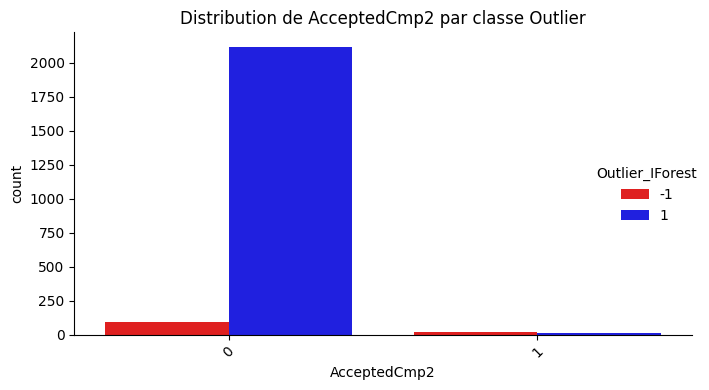

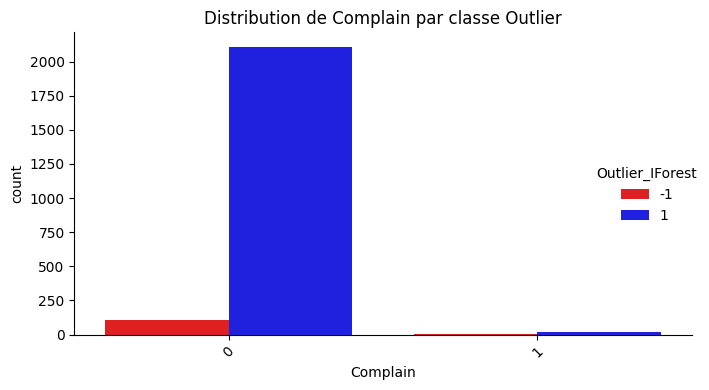

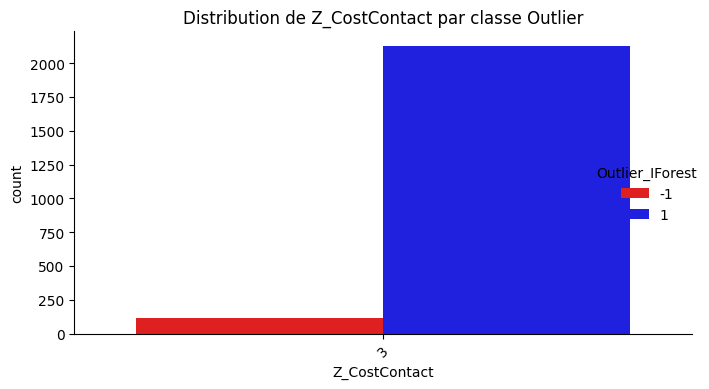

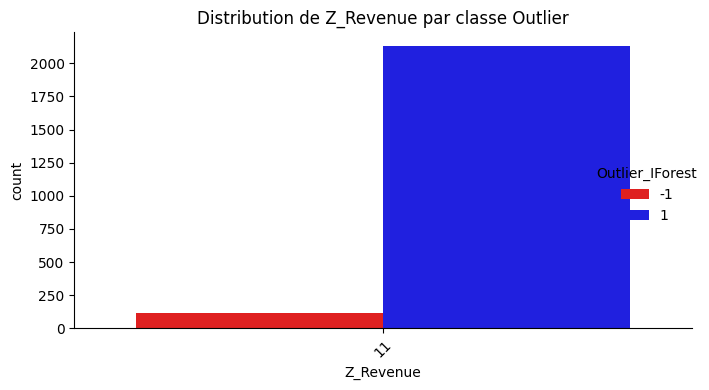

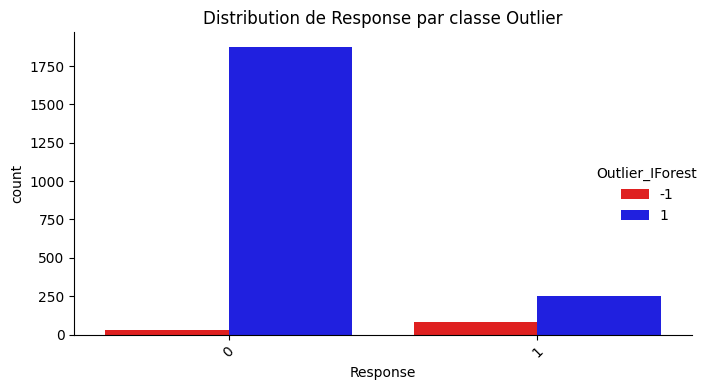

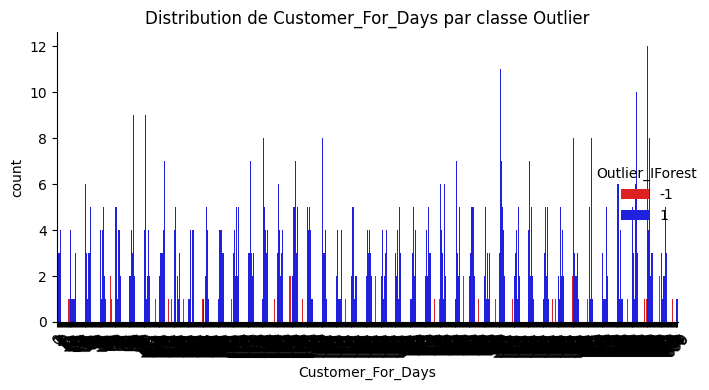

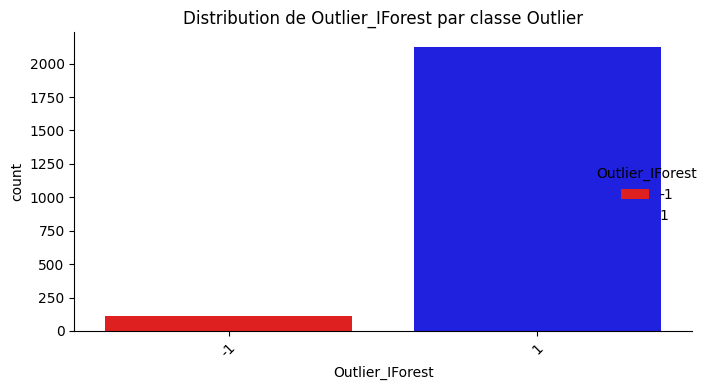

In [37]:
cat_cols = [col for col in df.columns]

for col in cat_cols:
    sns.catplot(data=df, x=col, kind='count', hue='Outlier_IForest', height=4, aspect=1.5, palette={1: "blue", -1: "red"})
    plt.title(f"Distribution de {col} par classe Outlier")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [34]:
sns.pairplot(df.select_dtypes(include='number'), corner=True)
plt.suptitle("Données avant suppression des outliers", y=1.02)
plt.show()

In [35]:
# Pourcentage de valeurs manquantes
missing = df.isna().mean().sort_values(ascending=False)
missing[missing > 0]

Income    0.010714
dtype: float64

## 2. Nettoyage et prétraitement

In [36]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Customer_For_Days'] = (pd.to_datetime('2024-01-01') - df['Dt_Customer']).dt.days

categorical_cols = ['Education', 'Marital_Status']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df = df.drop(['ID', 'Dt_Customer'], axis=1)

df = df.fillna(df.median(numeric_only=True))

KeyError: 'Dt_Customer'

In [ ]:
df.head()

### Standardisation

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

## 3. Réduction de dimension

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)
reduced_data = pca.fit_transform(scaled_data)
print('Nombre de composantes conservées :', pca.n_components_)

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('PCA - variance expliquée')
plt.show()

## 4. Méthodes de clustering

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=4, random_state=0)
labels_kmeans = kmeans.fit_predict(reduced_data)
sil_kmeans = silhouette_score(reduced_data, labels_kmeans)

cah = AgglomerativeClustering(n_clusters=4)
labels_cah = cah.fit_predict(reduced_data)
sil_cah = silhouette_score(reduced_data, labels_cah)

dbscan = DBSCAN(eps=2, min_samples=5)
labels_db = dbscan.fit_predict(reduced_data)
mask = labels_db != -1
sil_db = silhouette_score(reduced_data[mask], labels_db[mask]) if mask.sum() > 1 else np.nan

print('Silhouette K-means:', sil_kmeans)
print('Silhouette CAH:', sil_cah)
print('Silhouette DBSCAN:', sil_db)

### Visualisation des clusters (PCA 2D)

In [ ]:
pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(scaled_data)

fig, axes = plt.subplots(1,3, figsize=(15,4))
for ax, labels, title in zip(axes, [labels_kmeans, labels_cah, labels_db], ['K-means', 'CAH', 'DBSCAN']):
    ax.scatter(reduced_2d[:,0], reduced_2d[:,1], c=labels, cmap='tab10', s=10)
    ax.set_title(title)
plt.tight_layout()
plt.show()

## 5. Profiling des groupes

In [ ]:
df_clusters = df.copy()
df_clusters['Cluster_KMeans'] = labels_kmeans
profil_kmeans = df_clusters.groupby('Cluster_KMeans').mean(numeric_only=True)
profil_kmeans

## 6. Conclusion

Les différentes méthodes de clustering présentent des performances variables selon le score de silhouette.
Les groupes obtenus peuvent être étudiés au travers des moyennes des variables pour identifier des profils types de clients.